# Data Visualization

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from dataset import DICOMDataset
from dataloader import DataLoader
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


Create dataset

In [2]:
data_path = 'data/final_data'
data = DICOMDataset(data_path, only_complete=True)
print('Dataset contains %d items' % len(data))

Dataset contains 46 items


Load and visualize one of the data samples

Image shape: (256, 256)
Mask shape: (256, 256)


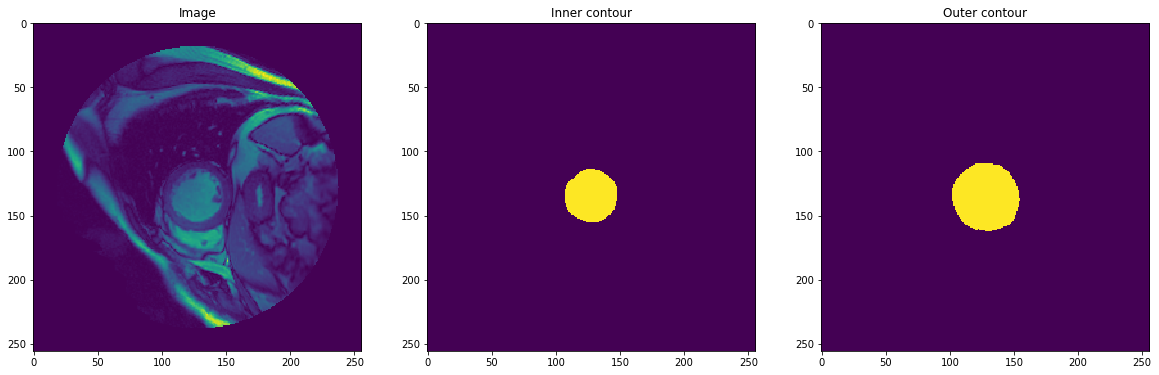

In [3]:
sample = data[1]
print('Image shape:', sample['pixel_data'].shape)
print('Mask shape:', sample['imask'].shape)
plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(131)
plt.title('Image')
plt.imshow(sample['pixel_data'])
plt.subplot(132)
plt.imshow(sample['imask'])
plt.title('Inner contour')
plt.subplot(133)
plt.imshow(sample['omask'])
plt.title('Outer contour')
plt.show()

Create dataloader

In [4]:
loader = DataLoader(data, batch_size=9, shuffle=True)

In [5]:
for batch in loader:
    print(batch['pixel_data'].shape, batch['imask'].shape, batch['omask'].shape)

(9, 256, 256) (9, 256, 256) (9, 256, 256)
(9, 256, 256) (9, 256, 256) (9, 256, 256)
(9, 256, 256) (9, 256, 256) (9, 256, 256)
(9, 256, 256) (9, 256, 256) (9, 256, 256)
(9, 256, 256) (9, 256, 256) (9, 256, 256)
(1, 256, 256) (1, 256, 256) (1, 256, 256)


In [6]:
def masked_images(img, omask, imask, normalize=False):
    oimg = np.ma.MaskedArray(img, ~omask, dtype=np.float32)
    iimg = np.ma.MaskedArray(img, ~imask, dtype=np.float32)
    diffimg = np.ma.MaskedArray(img, ~np.logical_xor(imask, omask), dtype=np.float32)
    if normalize:
        maxval = oimg.max()
        minval = oimg.min()
        oimg = (oimg - minval)/(maxval - minval)
        iimg = (iimg - minval)/(maxval - minval)
        diffimg = (diffimg - minval)/(maxval - minval)
        
    return oimg, iimg, diffimg


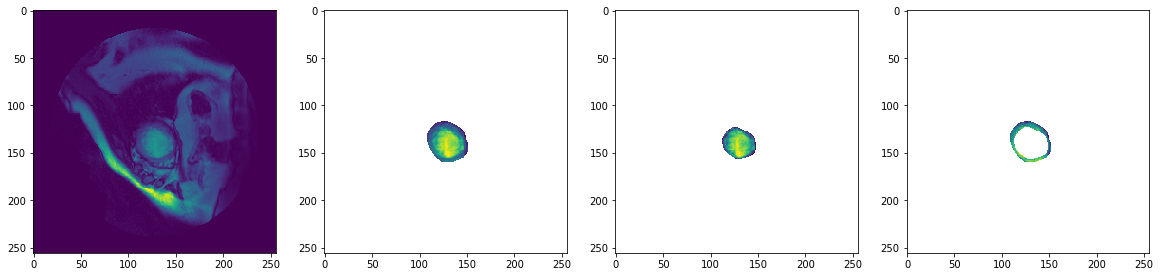

In [7]:
sample = data[5]
oimg, iimg, diffimg = masked_images(sample['pixel_data'], sample['omask'], sample['imask'])

plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(141)
plt.imshow(sample['pixel_data'])
plt.subplot(142)
plt.imshow(oimg)
plt.subplot(143)
plt.imshow(iimg)
plt.subplot(144)
plt.imshow(diffimg)
plt.show()

To decide if it posiible to use threshold to differentiate between pixels inside the blood pool (inside the i-contour) and pixels inside the heart muscle (between the i-contours and o-contours), lets first plot histogram of pixel intensities for some image.

445.0


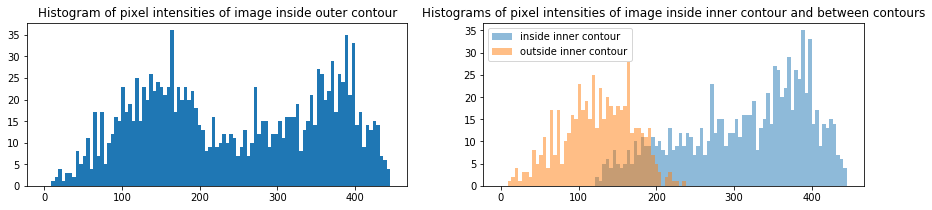

In [8]:
plt.rcParams['figure.figsize'] = [15, 3]
maxval = oimg.max()
print(maxval)
plt.subplot(121)
plt.hist(oimg[oimg.mask == False], bins=np.linspace(0, maxval, 100))
plt.title('Histogram of pixel intensities of image inside outer contour')
plt.subplot(122)
plt.hist(iimg[iimg.mask == False], bins=np.linspace(0, maxval, 100), alpha=0.5, label='inside inner contour')
plt.hist(diffimg[diffimg.mask == False], bins=np.linspace(0, maxval, 100), alpha=0.5, label='outside inner contour')
plt.title('Histograms of pixel intensities of image inside inner contour and between contours')
pyplot.legend(loc='upper left')
plt.show()

We can see that pixel intensities inside and outside inner contour are from different distributions. Now lets normalize pixel intensities inside outer contour for each image so that each pixel value belongs to interval [0, 1]. Now we can compute median values of pixel intensities inside and outside inner contour for each image.

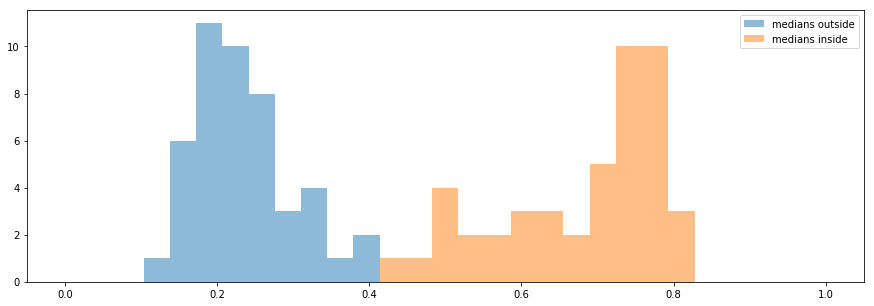

In [9]:
loader = DataLoader(data, batch_size=1, shuffle=True)
medivals = []
medovals = []
for batch in loader:
    img = batch['pixel_data'][0]
    imask = batch['imask'][0]
    omask = batch['omask'][0]
    oimg, iimg, diffimg = masked_images(img, omask=omask, imask=imask, normalize=True)
    
    medivals.append(np.ma.median(iimg))
    medovals.append(np.ma.median(diffimg))
plt.rcParams['figure.figsize'] = [15, 5]
plt.hist(medovals, bins=np.linspace(0, 1, 30), alpha=0.5, label='medians outside')
plt.hist(medivals, bins=np.linspace(0, 1, 30), alpha=0.5, label='medians inside')
pyplot.legend(loc='upper right')
plt.show()

From this histogram we can see that median values of intensities inside inner contour are clearly different from median values of intensities outside inner contour. That means that simple threshold for creating inner contour will work.

We can now plot ROC curve for classification of pixels inside outer contour of all images with different thresholds for intensisties. As we can see, area under curve value is much bigger than 0.5

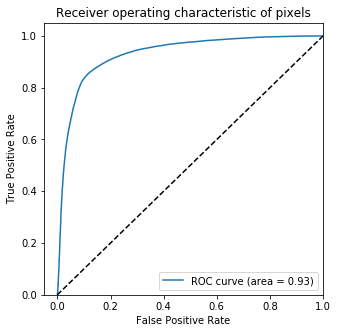

In [11]:
from sklearn.metrics import roc_curve, auc
loader = DataLoader(data, batch_size=1, shuffle=True)
ground_truth_list = []
scores_list = []
fig, ax = plt.subplots(1,1)
for batch in loader:
    img = batch['pixel_data'][0]
    imask = batch['imask'][0]
    omask = batch['omask'][0]
    oimg, iimg, diffimg = masked_images(img, omask=omask, imask=imask, normalize=True)
    ground_truth = np.ma.MaskedArray(imask, ~omask)
    ground_truth_list.append(ground_truth[ground_truth.mask == False])
    scores_list.append(oimg[oimg.mask == False])

ground_truth = np.concatenate(ground_truth_list)
scores = np.concatenate(scores_list)
fpr, tpr, _ = roc_curve(ground_truth, scores)
roc_auc = auc(fpr,tpr)
plt.rcParams['figure.figsize'] = [5, 5]
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic of pixels')
ax.legend(loc="lower right")
plt.show()

We can also show mask generater with some threshold for one of the images.

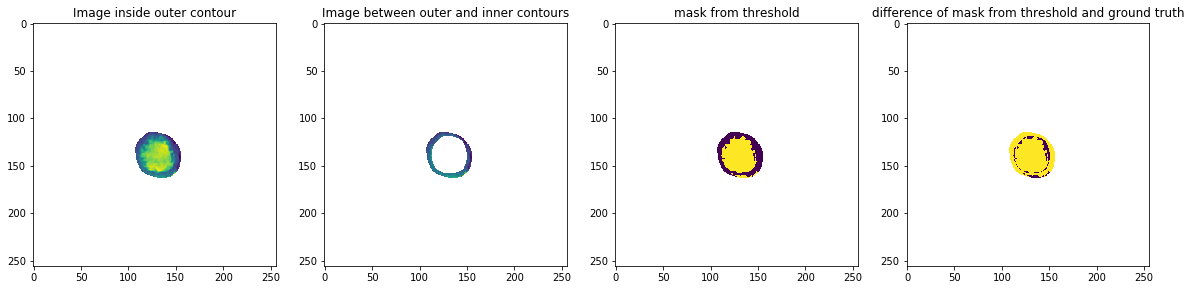

In [12]:
sample = data[6]
threshold = 0.45
oimg, iimg, diffimg = masked_images(sample['pixel_data'], sample['omask'], sample['imask'], normalize=True)
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(141)
plt.title('Image inside outer contour')
plt.imshow(oimg)
plt.subplot(142)
plt.title('Image between outer and inner contours')
plt.imshow(diffimg)
plt.subplot(143)
plt.imshow(oimg > threshold)
plt.title('mask from threshold')
plt.subplot(144)
plt.imshow((oimg > threshold) == sample['imask'])
plt.title('difference of mask from threshold and ground truth')
plt.show()